In [0]:
##Written by Roshan Noronha
##Date: November 1, 2019
##Purpose: The purpose of this notebook is to use transfer learning to improve the accuracy of a convolutional neural network. In this context, any improvement over 79% (results of the basic CNN) is considered an improvement.

In [0]:
#link google drive
#the trained model will be saved in google drive to be accessed later
#THIS IS IMPORTANT!
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#get dog and cat pictures from kaggle
#https://www.kaggle.com/general/74235
#command line commands are prefaced with a !

#import kaggle.json
#!pip install -q kaggle
#from google.colab import files
#files.upload()

#kaggle.json is saved in Google Drive
#copy it over to the working directory
!cp /content/drive/My\ Drive/Colab\ Notebooks/hotdognotahotdog/kaggle.json  /content/

In [0]:
#create a kaggle directory and move files the kaggle.json file there
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permissions of kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

#check that kaggle datasets show up
!kaggle datasets list

In [0]:
#get test data that has been separated into dogs and cats and is in the correct folders. This makes things easier.
!kaggle datasets download -d chetankv/dogs-cats-images

#unzip training and testing data
!unzip dogs-cats-images.zip
!unzip dog\ vs\ cat.zip

In [0]:
#specify tensorflow 1.14 as the colab default is 2.0.
#using 2.0 will lead to issue
!pip install tensorflow-gpu==1.14
import tensorflow as tf
print(tf.__version__)

In [0]:
#import keras and dependancies
#for importing vgg16 use keras.applications NOT keras_applications. Otherwise issues will occur.
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D, ZeroPadding2D, Reshape
from keras.preprocessing.image import ImageDataGenerator, image, img_to_array
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D


In [0]:
#define paths to training and testing folders
train_data = "dataset/training_set/"
test_data = "dataset/test_set/"

#preprocess images
img_width, img_height = 224,224

#rescale pixel values from [0-255] to [0-1]
datagen = ImageDataGenerator(rescale=1./255)

#really important that class_mode be set to "categorical"
train_gen = datagen.flow_from_directory(train_data, target_size= (img_width, img_height), batch_size= 25, shuffle = True, class_mode= "categorical")
validation_gen = datagen.flow_from_directory(test_data, target_size= (img_width, img_height), batch_size= 25, shuffle = True, class_mode= "categorical")

In [0]:
#import and show summary of VGG16
vggmodel = VGG16(include_top = False, weights = "imagenet", input_shape= (img_width, img_height, 3))
print(vggmodel.summary())

In [0]:
#create a sequential model and add the vgg16 layers to it
model = Sequential()
model.add(vggmodel)

#add the last layer of the model so it outputs a probability for cats and dogs
model.add(Flatten())
model.add(Dense(2, activation= "softmax"))

#freeze the pretrained layers
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
model.fit_generator(train_gen, steps_per_epoch= 400, epochs= 5, validation_data= validation_gen, validation_steps= 10)
model.save("/content/drive/My Drive/Colab Notebooks/dognotdog/dognotdog-transferlearning/trainedmodels/V5-dognotdog.h5")


In [0]:
#load trained model for testing
trainedmodel = load_model("/content/drive/My Drive/Colab Notebooks/dognotdog/dognotdog-transferlearning/trainedmodels/V5-dognotdog.h5")

In [0]:
#get dog and cat pictures from kaggle
!kaggle competitions download -c dogs-vs-cats

#unzip training and testing data
!unzip train.zip -d train
!unzip test1.zip -d test

#the training folder has dog and cat images together. These need to be in two seperate folders.
!mkdir train/cats/
!mkdir train/dogs/
!mkdir models/

!find train/train/ | grep "/dog.[0-9]*.jpg" | xargs mv -t train/dogs/
!find train/train/ | grep "/cat.[0-9]*.jpg" | xargs mv -t train/cats/

In [0]:
#train folder is empty so it should be removed
rm -r train/train/

In [0]:
#evaluate the effectiveness of the trained model
test_data = "train/"
test_gen = datagen.flow_from_directory(test_data, target_size= (img_width, img_height), batch_size= 32, class_mode= 'categorical')

print(trainedmodel.metrics_names)
print(trainedmodel.evaluate_generator(test_gen))

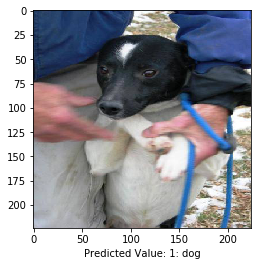

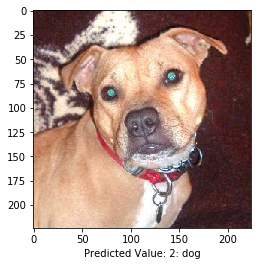

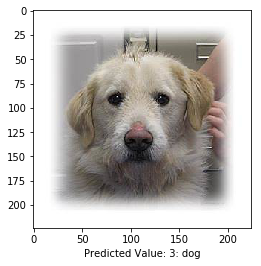

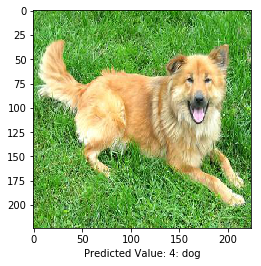

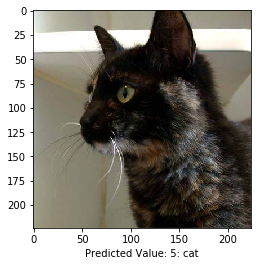

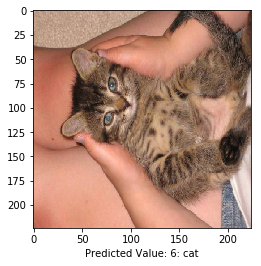

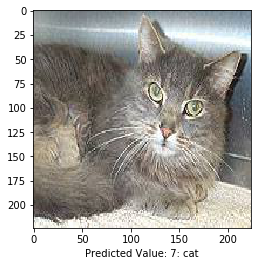

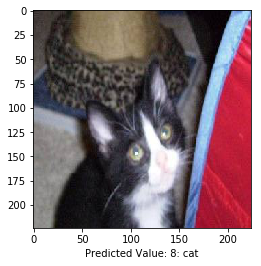

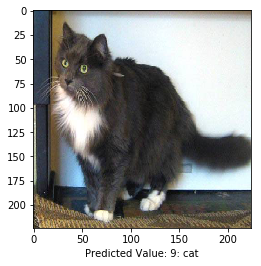

In [0]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(1, 10, 1):
  testImage = image.load_img("test/test1/" + str(i) + ".jpg", target_size= (224, 224))
  testImage = image.img_to_array(testImage)
  testImage = np.expand_dims(testImage, axis = 0)

  prediction = trainedmodel.predict(testImage)

  plt.imshow(image.load_img("test/test1/" + str(i) + ".jpg", target_size= (224, 224)))
  
  animal = ""
  if (int(prediction[0][0]) == 1):
    animal = str(i) + ": cat"
  else:
    animal = str(i) + ": dog"
    
  plt.xlabel("Predicted Value: " + animal)
  plt.show()
